# MERCADO INMOBILIARIO RUSO



In [ ]:
%%capture

!jupyter nbconvert --to html MercadoInmobiliarioRuso.ipynb

In [ ]:
%%capture

!pip install geopandas

In [ ]:
%%capture

!pip install scikit-learn-extra

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#import pprint
import datetime
from datetime import date
import folium
import geopandas as gp
from google.colab import drive
from keras import layers
from keras import models
from keras import optimizers
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
import pylab
import tensorflow as tf
from math import sqrt
import xgboost as xgb
from xgboost import XGBRegressor

ModuleNotFoundError: ignored

In [ ]:
#Para acceder a los ficheros de drive
drive.mount('/content/gdrive')
#Listamos los ficheros existentes en el directorio raiz
#!ls "/content/gdrive/MyDrive"

Mounted at /content/gdrive


Cargamos los datos de entrenamiento, validación y test.

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/DatosMercadoRuso/train.csv', parse_dates=['date'])
df_val = pd.read_csv('/content/gdrive/MyDrive/DatosMercadoRuso/val.csv', parse_dates=['date'])
df_test = pd.read_csv('/content/gdrive/MyDrive/DatosMercadoRuso/test.csv', parse_dates=['date'])

La hora de publicación de un anuncio no es un factor relevante, desde el punto de vista intuitivo, para la determinación del precio de la vivienda, por lo que la eliminamos del dataset. Por otro lado, borramos la columna 'rooms2' siguiendo las indicaciones del profesorado.

In [ ]:
del df_train['time']
del df_val['time']
del df_test['time']
del df_train['rooms2']

Mostramos la estructura del dataset.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54770 entries, 0 to 54769
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   price          54770 non-null  int64         
 1   date           54770 non-null  datetime64[ns]
 2   geo_lat        54770 non-null  float64       
 3   geo_lon        54770 non-null  float64       
 4   region         54770 non-null  int64         
 5   building_type  54770 non-null  int64         
 6   level          54770 non-null  int64         
 7   levels         54770 non-null  int64         
 8   rooms          54770 non-null  int64         
 9   area           54770 non-null  float64       
 10  kitchen_area   54770 non-null  float64       
 11  object_type    54770 non-null  int64         
 12  id             54770 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 5.4 MB


In [ ]:
df_train.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,id
0,1750000,2019-11-13,46.678285,38.291665,2843,3,3,5,1,33.00,10.00,1,212238
1,8498000,2020-02-10,55.605607,37.582161,3,1,2,9,3,50.00,9.00,1,193894
2,5100000,2019-09-14,56.726283,37.150735,81,3,1,9,2,57.00,11.00,1,106354
3,9151965,2021-04-24,55.866465,37.393784,81,2,4,10,2,57.00,10.20,11,48461
4,1669676,2018-12-24,55.017672,83.003522,9654,1,2,10,3,59.02,8.51,11,228556


In [ ]:
df_train.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,id
count,5.477000e+04,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000,54770.000000
mean,4.317436e+06,54.045159,53.349758,4318.844915,1.945171,6.248238,11.417418,1.727497,54.076744,10.660326,3.969144,136976.023900
std,1.420620e+07,4.607840,20.735021,3307.219233,1.037347,4.973697,6.520620,1.083690,38.225962,6.260846,4.569027,79080.056756
min,-2.114150e+09,41.459089,19.946227,3.000000,0.000000,1.000000,1.000000,-2.000000,1.210000,0.050000,1.000000,6.000000
25%,1.950000e+06,53.390538,37.787363,2661.000000,1.000000,2.000000,5.000000,1.000000,38.200000,7.000000,1.000000,68372.250000
50%,2.990000e+06,55.169801,43.561893,2922.000000,2.000000,5.000000,10.000000,2.000000,48.400000,9.800000,1.000000,136859.000000
75%,4.800000e+06,56.231155,65.659295,6171.000000,3.000000,9.000000,16.000000,2.000000,63.130000,12.800000,11.000000,205573.000000
max,6.800000e+08,69.498709,158.655925,14880.000000,5.000000,36.000000,39.000000,9.000000,4701.000000,444.000000,11.000000,273850.000000


# Limpieza del dataset

## Valores faltantes

Comprobamos que no existen valores nulos, con lo que no se lleva a cabo acción alguna.

In [ ]:
df_train.isnull().sum()

price            0
date             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
id               0
dtype: int64

## Limpieza de datos

Fusionamos en un único dataset los datos de entrenamiento y validación, pues vamos a hacer modificaciones sobre ambos conjuntos de datos

In [ ]:
df = pd.concat([df_train, df_val])

Eliminamos los registros cuya área sea menor de dos metros cuadrados.

In [ ]:
# registros con cocina menor de 2m
df_outlier_kitchen = df[df['kitchen_area'] < 2]
df = df[~df['id'].isin(df_outlier_kitchen['id'])]

Se calcula el área mínima en base a las indicaciones dadas en el problema.

In [ ]:
# Estimación del tamaño de la vivienda en función del tipo de vivienda 
TAMANYO_MIN_HABITACION = 9
TAMANYO_MIN_SALON = 12
TAMANYO_MIN_BANYO = 6
df['stm_minimum_area'] = [(x*TAMANYO_MIN_HABITACION + TAMANYO_MIN_SALON + TAMANYO_MIN_BANYO)*(1.1) if x != -1 else (TAMANYO_MIN_HABITACION + TAMANYO_MIN_BANYO)*(1.05) for x in df['rooms']]

Igualmente, eliminamos las viviendas con un área menor que el área mínima, con un umbral en función del tipo de vivienda.

In [ ]:
UMBRAL_PISO = 10
UMBRAL_ESTUDIO = 5

df_area_outlier = df[((df['rooms'] == -1) \
                    & (df['area'] < df['stm_minimum_area']) \
                    & (df['stm_minimum_area'] - df['area'] > UMBRAL_ESTUDIO)) \
                  | ((df['rooms'] != -1) \
                  & (df['area'] < df['stm_minimum_area']) \
                  & (df['stm_minimum_area'] - df['area'] > UMBRAL_PISO)) \
                  ]
df = df[~df['id'].isin(df_area_outlier['id'])]                 

Y se quitan las filas con valores de área negativos.

In [ ]:
# Eliminamos las filas con un valor de vivienda negativo
df_price_negative = df[df['price'] < 0]
df = df[~df['id'].isin(df_price_negative['id'])] 

## Outliers

Calculamos el precio por metro cuadrado e investigamos si la variable precio tiene una distribución conocida lo que, en tal caso, permitiría una caracterización sencilla de los outliers a partir de un intervalo de confianza.

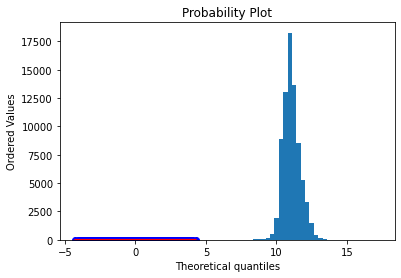

In [ ]:
# Por úlitmo, estudiamos la distribución de los precios
X_prices_m2 = df['price'] / df['area']
plt.hist(np.log(X_prices_m2), bins=50)
stats.probplot(np.log(X_prices_m2), dist="norm", plot=pylab)
pylab.show()

Realizamos el test de Jarque Bera de normalidad.

In [ ]:
jb_test = stats.jarque_bera(np.log(X_prices_m2))
jb_test.pvalue

NameError: ignored

Puesto que el p-valor es menor que el nivel de significación 0.05, rechazamos la hipotesis nula de normalidad.

In [ ]:
df['price_m2'] = df['price']/df['area']

Así pues, intentamos una descripción de los outliers con simple estadística descriptiva. El problema es que el recorrido intercuartílico es demasiado amplío y se eliminan demasiados datos con la fórmula estándar. Por tanto, hemos rebajado el peso del recorrido intercuartílico para la cota inferior del intervalo, obteniendo un valor razonable por el que filtrar.

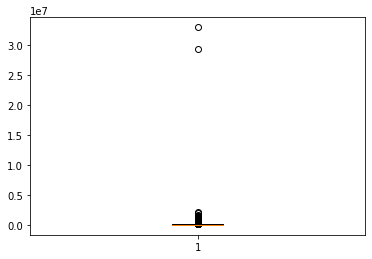

In [ ]:
plt.boxplot(X_prices_m2)

Q1 = df['price_m2'].quantile(0.25)
Q3 = df['price_m2'].quantile(0.75)
IQR = Q3-Q1
df_outliers = df[(df['price_m2']<(Q1-0.5*IQR)) | (df['price_m2']>(Q3+1.5*IQR))]

In [ ]:
# Cota inferior para el filtrado
Q1-0.5*IQR

18984.664198836603

Eliminamos los outliers.

In [ ]:
df = df[~df['id'].isin(df_outliers['id'])]

Borramos las variables auxiliares usadas para los cálculos.

In [ ]:
del df['stm_minimum_area']
del df['price_m2']

##  Ingeniería de características

Vamos a buscar nuevos predictores con los que mejorar la precisión en las predicciondes del modelo final. Empezamos añadiendo los predictores relacionados con las fechas.

In [ ]:
#  Separación en datos de validación y test
df_train = df[df['id'].isin(df_train['id'])]
df_val = df[df['id'].isin(df_val['id'])]

La primera variable que se añade es el número de días que el anuncio está publicado. Viviendas con mucho tiempo en el portal pueden indicar una baja demanda, por lo que es interesante considerar su inclusión como predictor.

In [ ]:
# Cálculo del nuevo predictor
d1 = datetime.datetime(2021,5,31)
df_train['n_days'] = [(d1 - x).days for x in df_train['date']]
df_val['n_days'] = [(d1 - x).days for x in df_val['date']]
df_test['n_days'] = [(d1 - x).days for x in df_test['date']]

Extraemos el mes y año de publicación como factores independientes.

In [ ]:
df_train['year'] = [x.year for x in df_train['date']]
df_val['year'] = [x.year for x in df_val['date']]
df_test['year'] = [x.year for x in df_test['date']]

In [ ]:
df_train['month'] = [x.month for x in df_train['date']]
df_val['month'] = [x.month for x in df_val['date']]
df_test['month'] = [x.month for x in df_test['date']]

Haremos una primera evaluación de la importancia de las variables entrenando un modelo XGboost.

In [ ]:

def check_metrics(model):
  print('Training MAE', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val, model.predict(X_val)))
  print('Training RMSE',   sqrt(mean_squared_error(y_train, model.predict(X_train))))
  print('Validation RMSE',   sqrt(mean_squared_error(y_val, model.predict(X_val))))
  print('Validation R^2', model.score(X_val, y_val))
  print('Training R^2',model.score(X_train, y_train))
  print()

In [ ]:
# Datos de entrenamiento y validación
y_train = df_train['price']
X_train = df_train.drop(columns=['price', 'date', 'id'])
y_val = df_val['price']
X_val = df_val.drop(columns=['price', 'date', 'id'])

In [ ]:
# Entrenamiento del algoritmo
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(X_train, y_train)

In [ ]:
#Métricas básicas del modelo
check_metrics(model_xgb)

Training MAE 684042.9223454633
Validation MAE 694410.5683919669
Training RMSE 1024084.50034527
Validation RMSE 1170735.4078814038
Validation R^2 0.7854819208565189
Training R^2 0.8303051090380568



Hacemos un ranking de las variables más importtantes.

In [ ]:
# Importancia de las variables
feature_list = list(X_train.columns)
importances = list(model_xgb.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: area                 Importance: 0.2800000011920929
Variable: geo_lon              Importance: 0.20999999344348907
Variable: region               Importance: 0.11999999731779099
Variable: levels               Importance: 0.09000000357627869
Variable: kitchen_area         Importance: 0.09000000357627869
Variable: geo_lat              Importance: 0.05000000074505806
Variable: rooms                Importance: 0.03999999910593033
Variable: object_type          Importance: 0.03999999910593033
Variable: n_days               Importance: 0.03999999910593033
Variable: building_type        Importance: 0.019999999552965164
Variable: level                Importance: 0.009999999776482582
Variable: year                 Importance: 0.0
Variable: month                Importance: 0.0


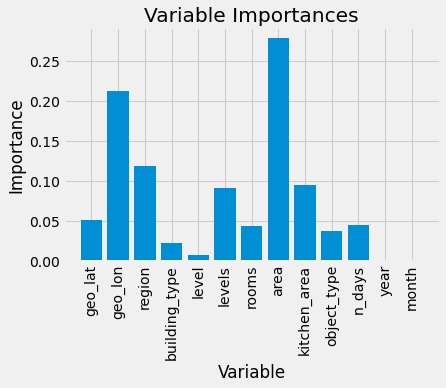

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Gráfico de la importancia de los predictores
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Se pueden extraer dos conclusiones:

  - La fecha de publicación no tiene ningún peso en la explicación de la varianza de los precios, por lo que podemos eliminar las variables y simplificar el problema
  - Aunque las coordenadas están embebidas en la región, tienen un papel importante en la predicción, por lo que es interesante incorporar esta información al dataset de alguna manera

In [ ]:
# Eliminamos todas las variables relativas a la fecha de publicación
del df_train['year']
del df_val['year']
del df_test['year']

del df_train['month']
del df_val['month']
del df_test['month']

del df_train['date']
del df_val['date']
del df_test['date']

In [ ]:
# Unimos lo datos de validación y de test
df = pd.concat([df_train, df_val])

En vista  de que las coordenadas parecen tener un papel en las predicciones relevante, vamos a incorporarlas al dataset de la siguiente manera:

  - Para cada región, vamos a considerar todas sus coordenadas en donde se ubican las ofertas y calcular zonas en donde haya una alta densidad de las mismas
  - Este cálculo se hará con un algoritmo de clusterización, concretamente con el kmedoids, ya que permite el cálculo automatizado de los clústers y es más robusto que kmeans frente a valores atípicos
  - Intuitivamente, vamos a descomponer cada región en subregiones agrupadas en función de la densidad y distribución de las viviendas

El siguiente trozo de código muestra el algoritmo de cálculo usando kmedoids.

In [ ]:
# Carga incremental
if os.path.isfile("/content/gdrive/MyDrive/ModelosMercadoRuso/ShilhouetteCoefficient.pkl"):
# Se almacena en este dataset los resultados hasta una iteración i (a veces colab cierra sesión y el bucle queda a medio)
  df_area_shil = pd.read_pickle("/content/gdrive/MyDrive/ModelosMercadoRuso/ShilhouetteCoefficient.pkl")
else:
# La primera vez que se ejecuta, se crea un nuevo dataframe
  df_area_shil = pd.DataFrame(columns=['region', 'shilhouette_coef'])

# Cálculo de las regiones no  calculadas anteriormente
region = pd.unique(df[~df['region'].isin(df_area_shil['region'])]['region'])
 
for r in region:
  #print(r)
  Shilhouette_coefficient = []
  # Coordenadas de la región
  t_df_coor = df[df['region'] == r][['geo_lat', 'geo_lon']]
  # Conjunto de clústers candidatos
  K = range(2,min(8, t_df_coor.shape[0]))
  for k in K:
      km = KMedoids(n_clusters=k, method = 'pam')
      km.fit_predict(t_df_coor)
      #print(silhouette_score(t_df_coor, km.labels_,  metric='euclidean'))
      # Se usa la métrica silhouette para calcular la bondad del ajuste. Ésta mide la separabilidad entre los clusters. 1 es el valor  óptimo
      # Almacenamos todos los cálculos en el dataframe de salida
      Shilhouette_coefficient.append(silhouette_score(t_df_coor, km.labels_,  metric='euclidean'))
  # Carga incremental de los cálculos (por problemas de fin de sesión en Google Colab)
  df_area_shil = df_area_shil.append({'region':r, 'shilhouette_coef':Shilhouette_coefficient}, ignore_index=True)
  df_area_shil.to_pickle("/content/gdrive/MyDrive/ModelosMercadoRuso/ShilhouetteCoefficient.pkl")

Otras opciones interesantes para este caso son una red SOM con un posterior cálculo de los clústers o aplicar la clusterización de manera recursiva, descomponiende las subregiones en regiones más finas. 

Éstos son los resultados de los cálculos. El dataframe se compone de:

    - El identificador de la región
    - La métrica de Shilhouette para cada k, siendo k el parámetro que regula el número de medoides en el entrenamiento

In [ ]:
df_area_shil

,region,shilhouette_coef
0,2843,"[0.6937100926921465, 0.8137128702764954, 0.803..."
1,81,"[0.39103684577567444, 0.4075291093010297, 0.42..."
2,9654,"[0.42045298862830754, 0.458200428158802, 0.507..."
3,6171,"[0.7897448469680157, 0.8197806310358798, 0.782..."
4,2661,"[0.3527478255151675, 0.4006835291842251, 0.317..."
...,...,...
77,13098,"[0.5639481871344132, 0.42896127034959736, 0.32..."
78,13913,"[0.5682301752910762, 0.5482430473944796, 0.614..."
79,69,[]
80,4963,[]


Se calculan la mejor métrica y número de cluster para cada región

In [ ]:
l = df_area_shil['shilhouette_coef'].tolist()
best_score=[None]*len(l)
num_cluster=[None]*len(l)
ran = range(0, len(l))
for r in ran:
  if(len(l[r]) > 0):
    #print(max(l[r]))
    t = max(l[r])
    best_score[r] = t
    num_cluster[r] = l[r].index(t) + 2
  else:
      #print(0)
      best_score[r] = 0
      num_cluster[r] = 1

In [ ]:
# incorporamos  los datos al dataframe
df_area_shil['best_score'] = best_score
df_area_shil['num_cluster'] = num_cluster

La calidad, en general, en la representación es bastante alta.

In [ ]:
df_area_shil['best_score'].mean()

0.794219326450354

Habiendo calculado el número óptimo de clusters en el que dividir una región, aplicamos el algoritmo kmedoid para cada región con sus correspondientes valores óptimos y calculamos las predicciones para los datos de entrenamiento, validación y test.

In [ ]:
if os.path.isfile("/content/gdrive/MyDrive/ModelosMercadoRuso/DatasetConClusters.pkl"):
# Carga incremental. Se almacenan los datos hasta una iteración i (colab puede cerrar sesión a mitad de los cálculos)
  df_tmp = pd.read_pickle("/content/gdrive/MyDrive/ModelosMercadoRuso/DatasetConClusters.pkl")
else:
# Creación de un dataframe con la misma estructura que los datos de entrenamiento
  df_tmp = pd.DataFrame(columns=df.columns)
  df_tmp['zone'] = np.nan

# Áreas para las que no se han hecho la predicciones
df_area = df_area_shil[~df_area_shil['region'].isin(df_tmp['region'])]

for idx in df_area.index:
  row = df_area_shil.iloc[idx]
  #print(row['region'])
  # Entrenamiento con el número de clusters óptimo

  if(row['num_cluster'] > 1):
    #Entrenamos el mejor modelo con los datos de entrenamiento + validación
    tmp = df[df['region'] == row['region']]
    tmp_coor = tmp[['geo_lat', 'geo_lon']]
    # Entrenamiento del algoritmo
    km = KMedoids(n_clusters=row['num_cluster'], method = 'pam')
    # Predicción para los datos de entrenamiento + validación
    tmp['zone'] = km.fit_predict(tmp_coor)
    df_tmp = df_tmp.append(tmp)
    # Predecimos los clusters para los datos de test
    tmp = df_test[df_test['region'] == row['region']]
    if(tmp.shape[0] > 0):
      tmp_coor = tmp[['geo_lat', 'geo_lon']]
      tmp['zone'] = km.predict(tmp_coor)
    else:
      tmp['zone'] = row['region']
    df_tmp = df_tmp.append(tmp)
  # Si el número óptimo de clusters es menor que  2, la zona es la región
  else:
    tmp = df[df['region'] == row['region']]
    tmp['zone'] = row['region']
    df_tmp = df_tmp.append(tmp) 
  df_tmp.to_pickle("/content/gdrive/MyDrive/ModelosMercadoRuso/DatasetConClusters.pkl")      

In [ ]:
del df_tmp['time']

Se muestra el dataset con los clústers incorporados. Por su interpretación, hemos llamado a esta variable zona.

In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75048 entries, 0 to 11685
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          69175 non-null  object 
 1   geo_lat        75048 non-null  float64
 2   geo_lon        75048 non-null  float64
 3   region         75048 non-null  object 
 4   building_type  75048 non-null  object 
 5   level          75048 non-null  object 
 6   levels         75048 non-null  object 
 7   rooms          75048 non-null  object 
 8   area           75048 non-null  float64
 9   kitchen_area   75048 non-null  float64
 10  object_type    75048 non-null  object 
 11  id             75048 non-null  object 
 12  n_days         75048 non-null  object 
 13  zone           75048 non-null  float64
dtypes: float64(5), object(9)
memory usage: 8.6+ MB


In [ ]:
# Tipamos los datos de las columnas del dataframe temporal a su tipo de datos correcto
df_tmp['zone'] = df_tmp['zone'].astype('int64')
df_tmp['region'] = df_tmp['region'].astype('int64')
df_tmp['building_type'] = df_tmp['building_type'].astype('int64')
df_tmp['level'] = df_tmp['level'].astype('int64')
df_tmp['levels'] = df_tmp['levels'].astype('int64')
df_tmp['rooms'] = df_tmp['rooms'].astype('int64')
df_tmp['area'] = df_tmp['area'].astype('float64')
df_tmp['kitchen_area'] = df_tmp['kitchen_area'].astype('float64')
df_tmp['object_type'] = df_tmp['object_type'].astype('int64')
df_tmp['n_days'] = df_tmp['n_days'].astype('int64')
df_tmp['id'] = df_tmp['id'].astype('int64')

In [ ]:
# Cálculo de los datos de entrenamiento, validación y test a partir del dataframe temporal. 'machacamos' los valosres antiguos
df_train = df_tmp[df_tmp['id'].isin(df_train['id'])]
df_val = df_tmp[df_tmp['id'].isin(df_val['id'])]
df_test = df_tmp[df_tmp['id'].isin(df_test['id'])]

In [ ]:
df_train['price'] = df_train['price'].astype('int64')
df_val['price'] = df_val['price'].astype('int64')

Una característica interesante a considerar es el precio medio por zona. Si realmente hay una diferencia significativa entre el precio medio por zona, esta variable va a recoger esa información.

In [ ]:
# Precio por zona
df_price_by_zone = df_train.groupby(['region', 'zone'])['price'].mean().reset_index().rename(columns={'price':'avg_price'})

In [ ]:
# Incorporamos la nueva variable al dataset
df_train = pd.merge(df_train, df_price_by_zone,how='inner', on=['region', 'zone'])
df_val = pd.merge(df_val, df_price_by_zone,how='inner', on=['region', 'zone'])
df_test = pd.merge(df_test, df_price_by_zone,how='inner', on=['region', 'zone'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49519 entries, 0 to 49518
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          49519 non-null  int64  
 1   geo_lat        49519 non-null  float64
 2   geo_lon        49519 non-null  float64
 3   region         49519 non-null  int64  
 4   building_type  49519 non-null  int64  
 5   level          49519 non-null  int64  
 6   levels         49519 non-null  int64  
 7   rooms          49519 non-null  int64  
 8   area           49519 non-null  float64
 9   kitchen_area   49519 non-null  float64
 10  object_type    49519 non-null  int64  
 11  id             49519 non-null  int64  
 12  n_days         49519 non-null  int64  
 13  zone           49519 non-null  int64  
 14  avg_price      49519 non-null  float64
dtypes: float64(5), int64(10)
memory usage: 6.0 MB


# Selección de variables

Es momento de comprobar que las nuevas variables añadidas son significativas. Para ello, volvemos a entrenar un modelo Xgboost sencillo, sin optimización de hiperparámeros, para ver la significatividad de los predictores añadidos.

In [ ]:
# Preparamos los datos para el entrenamiento
y_train = df_train['price']
X_train = df_train.drop(columns=['geo_lat', 'geo_lon', 'price', 'id'])
y_val = df_val['price']
X_val = df_val.drop(columns=['geo_lat', 'geo_lon', 'price', 'id'])

In [ ]:
# Entrenamiento del modelo
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(X_train, y_train)

In [ ]:
# Bondad del ajuste (si el modelo da resultados malos, quizás deberíamos buscar otro método)
check_metrics(model_xgb)

Training MAE 638003.3840281003
Validation MAE 648982.7469601477
Training RMSE 980060.8685770791
Validation RMSE 1124414.1621765075
Validation R^2 0.8022163230620293
Training R^2 0.8445812973408102



In [ ]:
# Importancia de las variables
feature_list = list(X_train.columns)
importances = list(model_xgb.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: avg_price            Importance: 0.41999998688697815
Variable: area                 Importance: 0.30000001192092896
Variable: kitchen_area         Importance: 0.07999999821186066
Variable: levels               Importance: 0.07000000029802322
Variable: n_days               Importance: 0.03999999910593033
Variable: object_type          Importance: 0.029999999329447746
Variable: region               Importance: 0.019999999552965164
Variable: rooms                Importance: 0.019999999552965164
Variable: building_type        Importance: 0.009999999776482582
Variable: level                Importance: 0.009999999776482582
Variable: zone                 Importance: 0.0


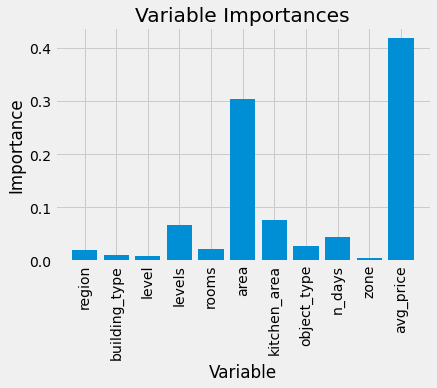

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Representación del histgrama de las variables

feature_list = list(X_train.columns)
# Set the style
importances = list(model_xgb.feature_importances_)
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

La variable zona no es significativa, pero sí lo es el precio medio, por lo que podemos considerar que se han representado las coordenadas en el dataset.

Vamos a seleccionar aquéllas variables que conserven el 95% de la varianza explicada, con ayuda del siguiente código.

Variable: avg_price            Importance: 0.41999998688697815
Variable: area                 Importance: 0.30000001192092896
Variable: kitchen_area         Importance: 0.07999999821186066
Variable: levels               Importance: 0.07000000029802322
Variable: n_days               Importance: 0.03999999910593033
Variable: object_type          Importance: 0.029999999329447746
Variable: region               Importance: 0.019999999552965164
Variable: rooms                Importance: 0.019999999552965164
Variable: building_type        Importance: 0.009999999776482582
Variable: level                Importance: 0.009999999776482582
Variable: zone                 Importance: 0.0


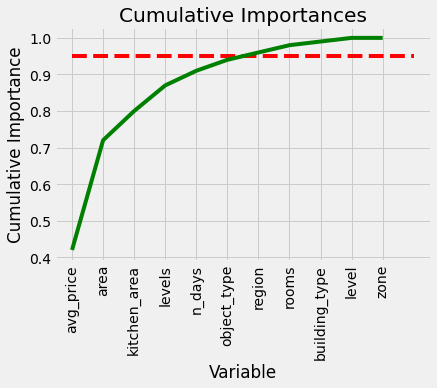

In [ ]:
# List of features sorted from most to least important

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

Vemos que las variables rooms, buildin_type y zone no aportan prácticamente nada al problema y pueden desecharse. Sin embargo, si eliminamos la variable level, perdemos información valiosa (cuanto más alto se sitúa una vivienda dentro de un edifio, más caro es). Para sintetizar esta información, vamos a incorporar la siguiente variable, que indica cómo de alto está el inmueble dentro del edifico.

In [ ]:
df_train['level_diff'] = df_train['levels'] - df_train['level']
df_val['level_diff'] = df_val['levels'] - df_val['level']
df_test['level_diff'] = df_test['levels'] - df_test['level']

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49519 entries, 0 to 49518
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          49519 non-null  int64  
 1   geo_lat        49519 non-null  float64
 2   geo_lon        49519 non-null  float64
 3   region         49519 non-null  int64  
 4   building_type  49519 non-null  int64  
 5   level          49519 non-null  int64  
 6   levels         49519 non-null  int64  
 7   rooms          49519 non-null  int64  
 8   area           49519 non-null  float64
 9   kitchen_area   49519 non-null  float64
 10  object_type    49519 non-null  int64  
 11  id             49519 non-null  int64  
 12  n_days         49519 non-null  int64  
 13  zone           49519 non-null  int64  
 14  avg_price      49519 non-null  float64
 15  level_diff     49519 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 6.4 MB


Eliminamos el resto de variables, simplificando así el problema.

In [ ]:
del df_train['zone']
del df_val['zone']
del df_test['zone']

del df_train['rooms']
del df_val['rooms']
del df_test['rooms']

del df_train['building_type']
del df_val['building_type']
del df_test['building_type']

del df_train['level']
del df_val['level']
del df_test['level']


del df_train['levels']
del df_val['levels']
del df_test['levels']

## Entrenamiento de la red y optimización de los hiperparámetros



En esta sección se entrenarán los modelos sobre el dataset obtenido en la sección anterior.

In [ ]:
df_train_trans = df_train
df_val_trans = df_val
df_test_trans = df_test

Eliminamos las coordenadas, ya que no van a ser usadas en adelante

In [ ]:
del df_train_trans['geo_lat']
del df_val_trans['geo_lat']
del df_test_trans['geo_lat']

del df_train_trans['geo_lon']
del df_val_trans['geo_lon']
del df_test_trans['geo_lon']

Convertimos los factores al tipo adecuado

In [ ]:
for col in ['object_type']:
    df_train_trans[col] = df_train_trans[col].astype('category')
    df_val_trans[col] = df_val_trans[col].astype('category')
    df_test_trans[col] = df_test_trans[col].astype('category')

Usamos la codificación one hot encoding para las categorías.

In [ ]:
df_train_trans = pd.get_dummies(df_train_trans, columns=['object_type'])
df_val_trans = pd.get_dummies(df_val_trans, columns=['object_type'])
df_test_trans = pd.get_dummies(df_test_trans, columns=['object_type'])

Normalizamos las variables de tipo numérico

In [ ]:
for col in ['level_diff', 'area', 'kitchen_area', 'n_days', 'avg_price', 'region']:
    mean = df_train_trans.append(df_val_trans)[col].mean(axis=0)
    std = df_train_trans.append(df_val_trans)[col].std(axis=0)
    df_train_trans[col] -= mean
    df_train_trans[col] /= std
    df_val_trans[col] -= mean
    df_val_trans[col] /= std
    df_test_trans[col] -= mean
    df_test_trans[col] /= std

Convertimos los datos a tensores para poder operar con la red neuronal.

In [ ]:
y_train = np.array(df_train_trans['price'])
X_train = np.array(df_train_trans.drop(columns=['price', 'id']))
y_val = np.array(df_val_trans['price'])
X_val = np.array(df_val_trans.drop(columns=['price', 'id']))

Creación de la arquitectura:

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=1024, 
                                 activation='linear',
                                 input_shape=[X_train.shape[1]]))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              9216      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1025      
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

In [ ]:
num_epochs = 10
history = model.fit(X_train,
                    y_train,
                    epochs=num_epochs, 
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
1238/1238 [==============================] - 3s 2ms/step - loss: 18522033881088.0000 - mse: 18522033881088.0000 - val_loss: 10361214337024.0000 - val_mse: 10361214337024.0000
Epoch 2/10
1238/1238 [==============================] - 2s 2ms/step - loss: 17998909800448.0000 - mse: 17998909800448.0000 - val_loss: 10074616496128.0000 - val_mse: 10074616496128.0000
Epoch 3/10
1238/1238 [==============================] - 2s 1ms/step - loss: 17431358603264.0000 - mse: 17431358603264.0000 - val_loss: 9759818252288.0000 - val_mse: 9759818252288.0000
Epoch 4/10
1238/1238 [==============================] - 2s 2ms/step - loss: 16814935375872.0000 - mse: 16814935375872.0000 - val_loss: 9420629082112.0000 - val_mse: 9420629082112.0000
Epoch 5/10
1238/1238 [==============================] - 2s 2ms/step - loss: 16153776750592.0000 - mse: 16153776750592.0000 - val_loss: 9057893089280.0000 - val_mse: 9057893089280.0000
Epoch 6/10
1238/1238 [==============================] - 2s 1ms/step - loss: 

Los datos obtenidos están lejos de ser buenos, por lo que probaremos otro modelo conocido.

### Entrenamiento modelo Xgboost mediante fine tunning

Busacamos el mejor modelo a traves de la malla de hiperparámetros del modelo Xgboost. Como valores iniciales, vamos a usar un modelo entrenado sin optimización de hiperparámetros.

In [ ]:
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)
model_xgb.fit(X_train, y_train)

In [ ]:
check_metrics(model_xgb)

Training MAE 674060.853530968
Validation MAE 683395.0130156608
Training RMSE 1021331.8081203008
Validation RMSE 1146065.0087358176
Validation R^2 0.794526254058612
Training R^2 0.8312161471626981



In [ ]:
# malla inicial de hiperparámetros
params = {
    'max_depth':model_xgb.max_depth,
    'min_child_weight': model_xgb.min_child_weight,
    'eta':.1,
    'subsample': model_xgb.subsample,
    'colsample_bytree': model_xgb.colsample_bytree,
    'objective':'reg:squarederror',
}


In [ ]:
y_train = df_train_trans['price']
X_train = df_train_trans.drop(columns=['price', 'id'])
X_train_id = df_train_trans['id']
y_val = df_val_trans['price']
X_val = df_val_trans.drop(columns=['price', 'id'])
X_val_id = df_val_trans['id']
y_test = df_test_trans['price']
X_test = df_test_trans.drop(columns=['price', 'id'])
X_test_id = df_test_trans['id']

Preparamos los datos de entrenamiento y validación.

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names =X_train.columns.to_list())
dval = xgb.DMatrix(X_val, label=y_val, feature_names =X_val.columns)

Búsqueda de los mejores hiperparámetros.

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,10)
    for min_child_weight in range(1,10)
]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

num_boost_round = 999
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=3, min_child_weight=1
	RMSE 1058660.95 for 331 rounds
CV with max_depth=3, min_child_weight=2
	RMSE 1057965.7875 for 298 rounds
CV with max_depth=3, min_child_weight=3
	RMSE 1064130.25 for 209 rounds
CV with max_depth=3, min_child_weight=4
	RMSE 1074654.5875 for 129 rounds
CV with max_depth=3, min_child_weight=5
	RMSE 1068384.925 for 290 rounds
CV with max_depth=3, min_child_weight=6
	RMSE 1071703.9625 for 157 rounds
CV with max_depth=3, min_child_weight=7
	RMSE 1072977.725 for 147 rounds
CV with max_depth=3, min_child_weight=8
	RMSE 1072808.5125 for 201 rounds
CV with max_depth=3, min_child_weight=9
	RMSE 1076499.35 for 107 rounds
CV with max_depth=4, min_child_weight=1
	RMSE 1053910.95 for 213 rounds
CV with max_depth=4, min_child_weight=2
	RMSE 1053983.725 for 218 rounds
CV with max_depth=4, min_child_weight=3
	RMSE 1054232.7625 for 204 rounds
CV with max_depth=4, min_child_weight=4
	RMSE 1061637.75 for 161 rounds
CV with max_depth=4, min_child_weight=5
	RMSE 10682

In [ ]:
params['max_depth'] = 6
params['min_child_weight'] = 2

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
num_boost_round = 999
min_rmse = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 1045456.9625 for 221 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 1053634.6375 for 131 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 1045614.6375 for 179 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 1048589.7875 for 202 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 1050516.375 for 176 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 1049791.3125 for 135 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 1045124.525 for 176 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 1045771.8875 for 181 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 1057217.25 for 136 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 1054629.2625 for 136 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 1052237.775 for 137 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 1050214.25 for 178 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 1062241.275 for 64 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 1061855.25 for 68 rounds
CV with subsample=

In [ ]:
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8

In [ ]:
num_boost_round = 999
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005, 0.001]:
    print("CV with eta={}".format(eta))
    
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(eta, min_rmse))

CV with eta=0.3
	RMSE 1064705.9875 for 53 rounds
CV with eta=0.2
	RMSE 1058209.15 for 76 rounds
CV with eta=0.1
	RMSE 1045124.525 for 176 rounds
CV with eta=0.05
	RMSE 1045540.2375 for 332 rounds
CV with eta=0.01
	RMSE 1045027.0875 for 998 rounds
CV with eta=0.005
	RMSE 1056653.4375 for 998 rounds
CV with eta=0.001
	RMSE 1962588.85 for 998 rounds
Best params: 0.001, RMSE: 1045027.0875


In [ ]:
params['eta'] = 0.01

Entrenamiento del modelo final.

In [ ]:
num_boost_round = 5000

xgb_model_ft = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dval, "Test")],
    early_stopping_rounds=30
)

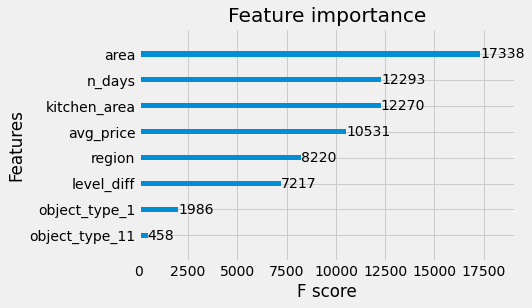

In [ ]:
xgb.plot_importance(xgb_model_ft)

In [ ]:
def print_result(model, data_to_pred, y):
  print('MAE', mean_absolute_error(y, model.predict(data_to_pred)))
  print('RMSE',   sqrt(mean_squared_error(y, model.predict(data_to_pred))))
  results = pd.DataFrame()
  results['pred'] = model.predict(data_to_pred)
  results['y'] = y
  reg_model = LinearRegression()
  X_pred = np.array(results['pred']).reshape(-1, 1)
  y = np.array(results['y']).reshape(-1, 1)
  reg_model.fit(X_pred, y)
  r_sq = reg_model.score(X_pred, y)
  print('coefficient of determination:', r_sq)
  plt.scatter(X_pred, y)
  plt.show()

MAE 587101.3880366627
RMSE 864715.5486679076
coefficient of determination: 0.8793380865820799


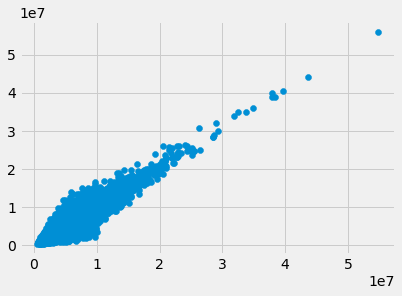

In [ ]:
print_result(xgb_model_ft, dtrain, y_train)

MAE 639628.2253374077
RMSE 1126221.7392867503
coefficient of determination: 0.8023235508548707


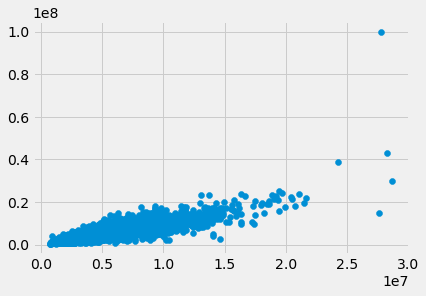

In [ ]:
print_result(xgb_model_ft, dval, y_val)

Parece que las predicciones cometen un error mayor en valores muy altos o bajos, por lo que sería interesante, en una segunda iteración, poner especial interés en estas casuísticas, ya que podría haber un patrón distinto al resto de casos.

Finalmente, guardamos las predicciones para los datos de test.

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test, feature_names = X_test.columns)

In [ ]:
final_pred = pd.DataFrame()

In [ ]:
CAMBIO_RUBLOS_EUROS = 90.06
final_pred['id'] = X_test_id
final_pred['pred_euros'] = pd.DataFrame(xgb_model_ft.predict(dtest)) / CAMBIO_RUBLOS_EUROS

In [ ]:
final_pred.to_csv(r'/content/gdrive/MyDrive/DatosMercadoRuso/predicciones.csv', index = False)

## Interpretación y conclusiones

Se ha conseguido explicar alrededor de un 80% de la varianza total de los precios. Los fatores más importantes son:

  - Área de la vivienda
  - Número de días en oferta (relacionado con la demanda)
  - Precio medio de la zona en la que se ubica
  - Región en la que se ubica la vivienda
  - Altura
  - Tipo de piso (nuevo o de segunda mano)

Faltan indicadores importantes en relación con la demanda de pisos, como el número de ofertas o el interés mostrado (número de visitas al inmueble).